/root/miniconda3/envs/FBQA_Hydrogen/lib/python3.10/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.3 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Qubits: 4
-0.09057898498092679 * I([0, 2, 1, 3]) + 0.17218393275012125 * Z(0) + -0.22575349261935956 * Z(2) + 0.12091263266645882 * (Z(0) @ Z(2)) + 0.1721839327501212 * Z(1) + 0.16892753874127636 * (Z(0) @ Z(1)) + 0.04523279993425406 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04523279993425406 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04523279993425406 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04523279993425406 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.22575349261935956 * Z(3) + 0.16614543260071288 * (Z(0) @ Z(3)) + 0.12091263266645882 * (Z(1) @ Z(3)) + 0.16614543260071288 * (Z(1) @ Z(2)) + 0.17464343072210142 * (Z(2) @ Z(3))
第 1 步: E = -0.09045528 Ha, β_1 = -0.000000
第 2 步: E = -0.09102499 Ha, β_2 = -0.018631
第 3 步: E = -0.09295124 Ha, β_3 = -0.037057
第 4 步: E = -0.09683344 Ha, β_4 = -0.055054
第 5 步: E = -0.10317282 Ha, β_5 = -0.072374
第 6 步: E = -0.11233930 Ha, β_6 = -0.088755
第 7 步: E = -0.12454333 Ha, β_7 = -0.103927
第 8 步: E = -0.13981701 Ha, β_8 = -0.117626
第 9 步: E = -0.15800859 Ha, β_9 = -0.129610
第 10 步: E

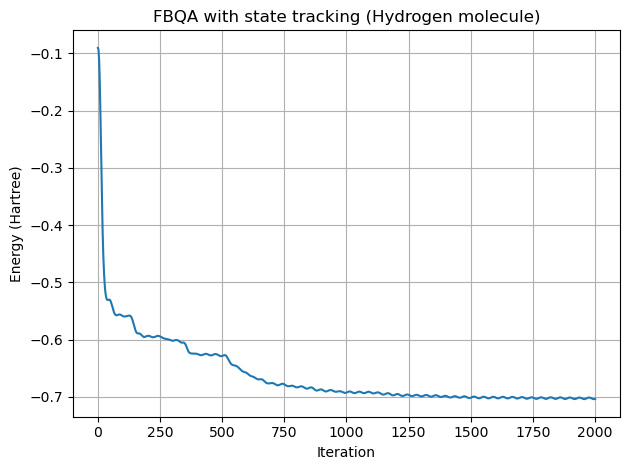

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.3889487]])  # 单位 Å

# 2. 分子哈密顿量（cost Hamiltonian）
H_c, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, method='pyscf', basis='sto-3g'
)
print("Qubits:", qubits)
print(H_c)
# 3. Driver Hamiltonian
def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(qubits)

# 4. 构造 commutator 哈密顿量
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, H_c)

# 5. 初始化量子态：|+>^n
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def plus_state():
    for w in range(qubits):
        qml.Hadamard(w)
    return qml.state()

# 6. 单步 FALQON 演化矩阵
def single_falqon_unitary(beta_k, delta_t, cost_h, driver_h):
    U_cost = qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    U_driver = qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)
    return qml.matrix(U_driver @ U_cost, wire_order=range(qubits))

# 7. 测量期望值 ⟨ψ|H|ψ⟩
def measure_expectation(state, H):
    H_mat = qml.matrix(H, wire_order=range(qubits))
    return np.real(np.vdot(state, H_mat @ state))

# 8. 主流程：状态保留式 FALQON
def run_fbqa_state_tracking(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = plus_state()

    for i in range(n_steps):
        # 计算 feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -1*delta_t * exp_comm
        beta_list.append(next_beta)

        # 应用下一步 unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, driver_h)
        state = U_k @ state

        # 计算能量
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 9. 设置参数并运行
n_steps = 2000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, driver_h, comm_h, n_steps, beta_1, delta_t)

# 10. 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
import pennylane as qml
print(qml.version())


0.41.1


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.74]])  # 单位 Å

# 2. 分子哈密顿量（cost Hamiltonian）
H_c, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, method='pyscf', basis='sto-3g'
)
print("Qubits:", qubits)
print(H_c)

Qubits: 4
0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))


In [4]:
# 获取 cost Hamiltonian 的项数
coeffs, ops = H_c.terms()
print(f"H_c 中的项数: {len(coeffs)}")

# （可选）打印前几项看看结构
for i in range(min(10, len(coeffs))):
    print(f"{coeffs[i]:.6f} * {ops[i]}")


H_c 中的项数: 15
0.778411 * I()
0.237187 * Z(0)
-0.461250 * Z(2)
0.140657 * Z(0) @ Z(2)
0.237187 * Z(1)
0.184561 * Z(0) @ Z(1)
0.041044 * Y(0) @ X(1) @ X(2) @ Y(3)
-0.041044 * Y(0) @ Y(1) @ X(2) @ X(3)
-0.041044 * X(0) @ X(1) @ Y(2) @ Y(3)
0.041044 * X(0) @ Y(1) @ Y(2) @ X(3)


In [5]:
print(H_c)


0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))


In [6]:
print(driver_h)


1.0 * X(0) + 1.0 * X(1) + 1.0 * X(2) + 1.0 * X(3)


In [7]:
print(comm_h)


(0.3443678655002425+0j) * Y(0) + (0.24182526533291765+0j) * (Y(0) @ Z(2)) + (0.3378550774825527+0j) * (Y(0) @ Z(1)) + (-0.09046559986850812+0j) * (Z(0) @ X(1) @ X(2) @ Y(3)) + (0.09046559986850812+0j) * (Z(0) @ Y(1) @ X(2) @ X(3)) + (0.33229086520142576+0j) * (Y(0) @ Z(3)) + (0.3443678655002424+0j) * Y(1) + (0.3378550774825527+0j) * (Z(0) @ Y(1)) + (0.09046559986850812+0j) * (Y(0) @ Z(1) @ X(2) @ X(3)) + (-0.09046559986850812+0j) * (X(0) @ Z(1) @ Y(2) @ X(3)) + (0.24182526533291765+0j) * (Y(1) @ Z(3)) + (0.33229086520142576+0j) * (Y(1) @ Z(2)) + (-0.4515069852387191+0j) * Y(2) + (0.24182526533291765+0j) * (Z(0) @ Y(2)) + (0.09046559986850812+0j) * (X(0) @ X(1) @ Z(2) @ Y(3)) + (-0.09046559986850812+0j) * (X(0) @ Y(1) @ Z(2) @ X(3)) + (0.33229086520142576+0j) * (Z(1) @ Y(2)) + (0.34928686144420285+0j) * (Y(2) @ Z(3)) + (-0.09046559986850812+0j) * (Y(0) @ X(1) @ X(2) @ Z(3)) + (0.09046559986850812+0j) * (X(0) @ X(1) @ Y(2) @ Z(3)) + (-0.4515069852387191+0j) * Y(3) + (0.33229086520142576+

In [8]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import qchem
# 1. 设置分子结构
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.74]])  # 单位 Å
molecule = qchem.Molecule(symbols, coordinates)
H, qubits = qchem.molecular_hamiltonian(molecule)
print("Number of qubits: {:}".format(qubits))
print("Qubit Hamiltonian")
print(H)                       

Number of qubits: 4
Qubit Hamiltonian
0.7784107516237697 * I([0, 1, 2, 3]) + 0.23718740030498464 * Z(0) + 0.23718740030498459 * Z(1) + 0.18456105296876102 * (Z(0) @ Z(1)) + -0.46124957076322376 * Z(2) + 0.14065700585010005 * (Z(0) @ Z(2)) + 0.18170118517545303 * (Z(1) @ Z(2)) + 0.04104417932535298 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417932535298 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417932535298 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417932535298 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495707632238 * Z(3) + 0.18170118517545303 * (Z(0) @ Z(3)) + 0.14065700585010005 * (Z(1) @ Z(3)) + 0.1917875056241929 * (Z(2) @ Z(3))


In [9]:
molecule = qchem.Molecule(symbols, coordinates)
H, qubits = qchem.molecular_hamiltonian(molecule, method="pyscf")
print(H)

0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))


In [10]:
molecule = qchem.Molecule(symbols, coordinates)
H, qubits = qchem.molecular_hamiltonian(molecule, method="pyscf")
print(H)

0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))


In [11]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.74]])  # 单位 Å

# 2. 分子哈密顿量（cost Hamiltonian）
cost_h, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, method='pyscf', basis='sto-3g'
)
print("Qubits:", qubits)
print(cost_h)
# 3. Driver Hamiltonian
def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(qubits)
print(driver_h)

# 4. 构造 commutator 哈密顿量
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1)

def build_maxclique_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz


def expval_circuit(beta, measurement_h):
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

def falqon( n, beta_1, delta_t, dev):
    comm_h = build_commutator_hamiltonian(driver_h, cost_h)

    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # The ansatz + measurement circuit is executable

    beta = [beta_1] # Records each value of beta_k
    energies = [] # Records the value of the cost function at each step

    for i in range(n):
        # Adds a value of beta to the list and evaluates the cost function
        beta.append(-1 * cost_fn(beta, measurement_h=comm_h))  # this call measures the expectation of the commuter hamiltonian
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian
        energies.append(energy)
        print(f"第 {i+1} 步: E = {energy:.8f} Ha")
    return beta, energies

n = 400
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=qubits) # Creates a device for the simulation
res_beta, res_energies = falqon(n, beta_1, delta_t, dev)
plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

Qubits: 4
0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))
1.0 * X(0) + 1.0 * X(1) + 1.0 * X(2) + 1.0 * X(3)
第 1 步: E = 0.77775067 Ha
第 2 步: E = 0.77565396 Ha
第 3 步: E = 0.77145745 Ha
第 4 步: E = 0.76450462 Ha
第 5 步: E = 0.75419454 Ha
第 6 步: E = 0.74001577 Ha
第 7 步: E = 0.72158888 Ha
第 8 步: E = 0.69871333 Ha
第 9 步: E = 0.67141103 Ha
第 10 步: E = 0.63995608 Ha
第 11 步: E = 0.60487908 Ha
第 12 步: E = 0.56693798 Ha
第 13 步: E = 0.52705405 Ha
第 14 步: E = 0.48622170 

KeyboardInterrupt: 